# Промежуточная аттестация по сетям искусcтвенных нейронов.

## Задание

**Ваша задача - создать классификатор изображений с помощью Keras и сверточных нейронных сетей для набора данных Fashion MNIST. Этот набор данных включает 10 меток с разными типами одежды с изображениями 28 на 28 _ в оттенках серого _. Имеется обучающий набор из 60 000 изображений и 10 000 тестовых изображений.**

Описание классов

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot


## Данные

**Загружаем данные**


In [18]:
from keras.datasets import fashion_mnist
import numpy as np


def load_data() -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    return fashion_mnist.load_data()


(train_images, train_labels), (test_images, test_labels) = load_data()

assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

## Визаулизация датасета

**Используйте matplotlib чтобы показать пример картинки.**


In [19]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

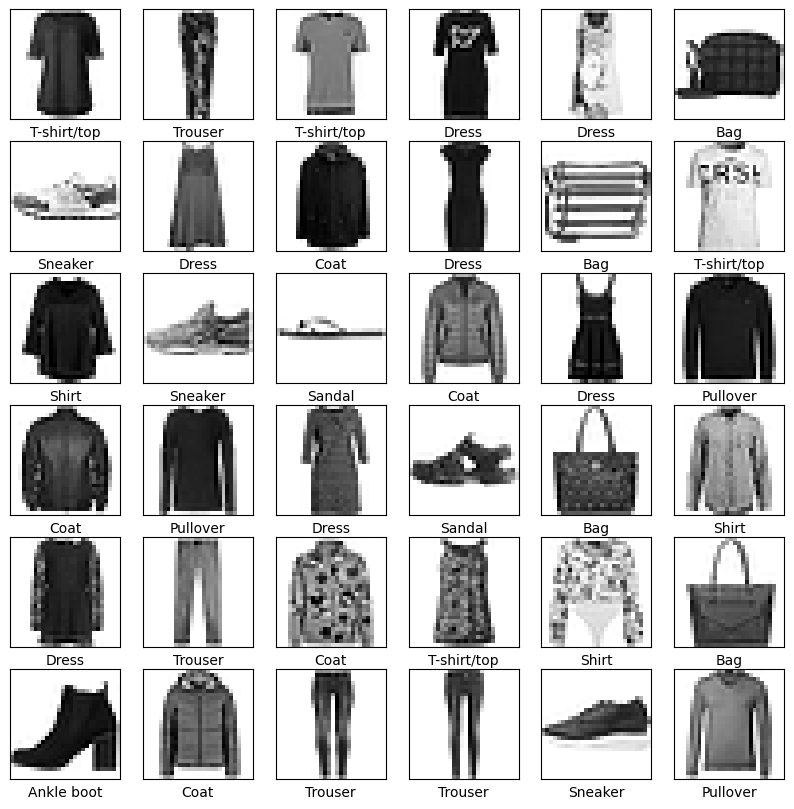

In [20]:
import matplotlib.pyplot as plt

item_idx = 42

random_idxs = np.random.choice(60000, 36)

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_idx = random_idxs[i]
    plt.imshow(np.squeeze(train_images[image_idx]), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[image_idx]])

## Предобработка

Нормализуйте данные X_train и X_test


In [21]:
train_images = (train_images / 255.0).astype(np.float32)
train_labels = (train_labels).astype(np.uint8)
test_images = (test_images / 255.0).astype(np.float32)
test_labels = (test_labels).astype(np.uint8)

### Измените форму массивов X_train и X_test так, чтобы они стали 4-мерными

batch_size x channels x H x W


In [22]:
train_images_reshaped = train_images.reshape(-1, 28, 28, 1)
test_images_reshaped = test_images.reshape(-1, 28, 28, 1)

### Преобразуйте y_train и y_test в one_hot представления


In [23]:
from keras.utils import to_categorical

train_labels_one_hot = to_categorical(train_labels, 10)
test_labels_one_hot = to_categorical(test_labels, 10)

## Создайте модель

**Примерная структура модели. При выполнении задания вы можете поэкспериментировать со слоями**

- Сверточный слой, 32 фильтра, размер ядра=(4,4)
- Пулинг с pool_size = (2,2)

- Выпрямляющий слой (Flatten)
- Полносвязный слой (например 128 нейронов), RELU

- Выходной полносвязный слой с 10 нейронами с softmax

**При компиляции укажите loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**


In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential(
    [
        Conv2D(32, kernel_size=(4, 4), activation="relu",
               input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

model.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               589952    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
________________________________________________

### Тренировка модели

**Тренируем модель на x_train. Число эпох выберите самостоятельно**


In [27]:
EPOCHS = 10
BATCH_SIZE = 64

model.fit(
    train_images_reshaped,
    train_labels_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # validation_data=(test_images_reshaped, test_labels_one_hot),
)

Epoch 1/10
198/938 [=====>........................] - ETA: 32s - loss: 0.5595 - accuracy: 0.7976

KeyboardInterrupt: 

### Оценка модели

**Оцените модель по метрикам accuracy,precision,recall,f1-score на тестовой выборке x_test **


['loss', 'acc']

In [30]:
print(classification_report(test_labels, predictions))

             precision    recall  f1-score   support

          0       0.86      0.85      0.85      1000
          1       0.99      0.97      0.98      1000
          2       0.88      0.83      0.85      1000
          3       0.91      0.91      0.91      1000
          4       0.83      0.88      0.85      1000
          5       0.97      0.98      0.98      1000
          6       0.73      0.76      0.74      1000
          7       0.95      0.97      0.96      1000
          8       0.99      0.97      0.98      1000
          9       0.98      0.94      0.96      1000

avg / total       0.91      0.91      0.91     10000



## Дополнительно

- Отрисуйте фильтры на слое Conv2D, сравните до и после обучения модели
